Source: https://github.com/robertmartin8/PyPortfolioOpt/blob/master/cookbook/4-Black-Litterman-Allocation.ipynb 

# Downloading data

In [206]:
# see install.md to get this working
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# PyPortfolioOpt
from pypfopt import risk_models, expected_returns
from pypfopt import black_litterman
from pypfopt import BlackLittermanModel, plotting
from pypfopt import EfficientFrontier, objective_functions

In [207]:
ETFs = ["SPY", "BND", "GLD", "HODL"]
ohlc = yf.download(ETFs, period="15y")  # Open, High, Low, Close
closing_prices = ohlc["Close"]
closing_prices.tail()

# Shows closing prices for the ETFs the last 5 days.


[*********************100%***********************]  4 of 4 completed


Ticker,BND,GLD,HODL,SPY
Date,,,,
2025-04-04,73.820000,279.720001,23.750000,505.279999
2025-04-07,72.930000,273.709991,22.080000,504.380005
2025-04-08,72.510002,275.200012,21.709999,496.480011
2025-04-09,72.680000,285.380005,23.250000,548.619995
2025-04-10,72.099998,292.350006,22.500000,524.580017


In [208]:
# Get closing prices, and show 5 latest ones. 
stock_prices = yf.download("SPY", period="15y")["Close"].dropna()
stock_prices.head()

[*********************100%***********************]  1 of 1 completed


Ticker,SPY
Date,
2010-04-12,90.992737
2010-04-13,91.061119
2010-04-14,92.094635
2010-04-15,92.170609
2010-04-16,90.703957


In [209]:
gold_prices = yf.download("GLD", period="15y")["Close"].dropna()
gold_prices.head()

[*********************100%***********************]  1 of 1 completed


Ticker,GLD
Date,
2010-04-12,113.010002
2010-04-13,112.690002
2010-04-14,113.029999
2010-04-15,113.650002
2010-04-16,111.239998


In [210]:
bond_prices = yf.download("BND", period="15y")["Close"].dropna()
bond_prices.head()

[*********************100%***********************]  1 of 1 completed


Ticker,BND
Date,
2010-04-12,51.450825
2010-04-13,51.554974
2010-04-14,51.515919
2010-04-15,51.594051
2010-04-16,51.704723


In [211]:
crypto_prices = yf.download("HODL", period="15y")["Close"].dropna()
crypto_prices.head()

[*********************100%***********************]  1 of 1 completed


Ticker,HODL
Date,
2024-01-11,13.230
2024-01-12,12.405
2024-01-16,12.300
2024-01-17,12.145
2024-01-18,11.605


In [212]:
# Only fetches market caps for SPY and GLD

# mcaps = {}
# for t in ETFs:
#     try:
#         mcaps[t] = yf.Ticker(t).info["marketCap"]
#     except KeyError:
#         print(f"Inget market cap för {t}")
# mcaps

# Using hardcoded values instead:
mcaps = {
    "SPY": 481_714_784_600,     # manuellt från https://www.nasdaq.com/market-activity/etf/spy
    "BND": 122_936_437_056,     # manuellt från https://www.nasdaq.com/market-activity/etf/bnd
    "GLD": 77_500_318_000,      # manuellt från https://www.nasdaq.com/market-activity/etf/gld
    "HODL": 1_200_295_500        # manuellt från https://www.nasdaq.com/market-activity/etf/hodl
}
mcaps

{'SPY': 481714784600,
 'BND': 122936437056,
 'GLD': 77500318000,
 'HODL': 1200295500}

# Constructing the prior

In [213]:
# Covariance matrix between all assets
cov_matrix = risk_models.CovarianceShrinkage(closing_prices).ledoit_wolf()
cov_matrix

Ticker,BND,GLD,HODL,SPY
Ticker,,,,
BND,0.003000,0.002201,-0.000002,0.000060
GLD,0.002201,0.023830,0.000874,0.001435
HODL,-0.000002,0.000874,0.025561,0.003060
SPY,0.000060,0.001435,0.003060,0.030109


In [214]:
# Risk aversion
delta = black_litterman.market_implied_risk_aversion(stock_prices)
print(delta)

4.343891584838672


<Axes: >

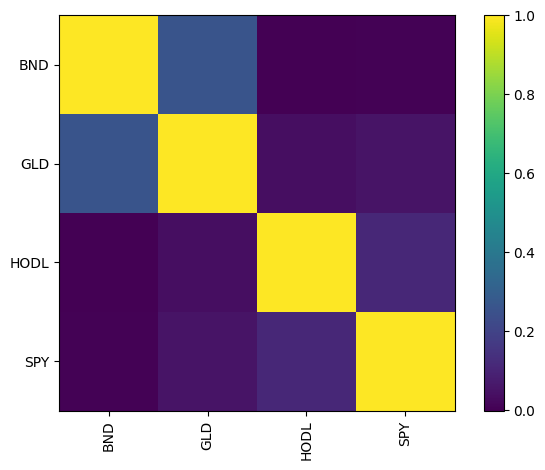

In [215]:
plotting.plot_covariance(cov_matrix, plot_correlation=True)

In [216]:
# Prior implied returns (Pi), N×1 column vector
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, cov_matrix)
market_prior

Ticker
BND     0.003611
GLD     0.017861
HODL    0.009995
SPY     0.092975
dtype: float64

<Axes: ylabel='Ticker'>

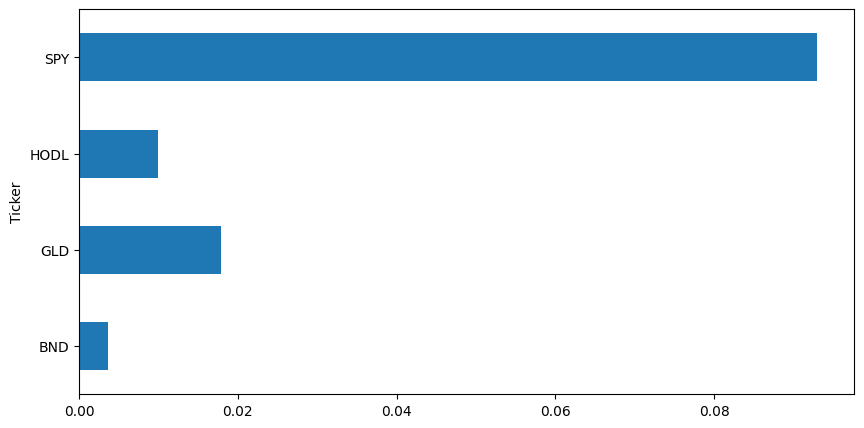

In [217]:
market_prior.plot.barh(figsize=(10,5))

# Views
Q contains the magnitude of each view, while P maps the views to the assets they belong to.

In [218]:
# Absolute views, this should be coming from XGBoost, placeholder values atm
viewdict = {
    "SPY": 0.08,      # t.ex. +8% förväntad avkastning
    "BND": 0.03,      
    "GLD": 0.01,      
    "HODL": 0.20,
}

# View confidence
Using Idzorek's method
 - Maybe we can use some error term to evaluate the confidence levels?

In [219]:
# Placeholder values:
confidences = [0.6, 0.5, 0.3, 0.7]

In [220]:
# Using idzorek method (specifying our own confidence levels)
# You can also create omega yourself by creating a diagonal matrix based on the views variances
bl_idzorek = BlackLittermanModel(cov_matrix, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

In [221]:
# Posterior estimate of returns
ret_bl = bl_idzorek.bl_returns()
ret_bl

Ticker
BND     0.016484
GLD     0.025082
HODL    0.142395
SPY     0.091579
dtype: float64

In [222]:
# Visualization how this compares to the prior and our views:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
BND,0.003611,0.016484,0.03
GLD,0.017861,0.025082,0.01
HODL,0.009995,0.142395,0.20
SPY,0.092975,0.091579,0.08


<Axes: >

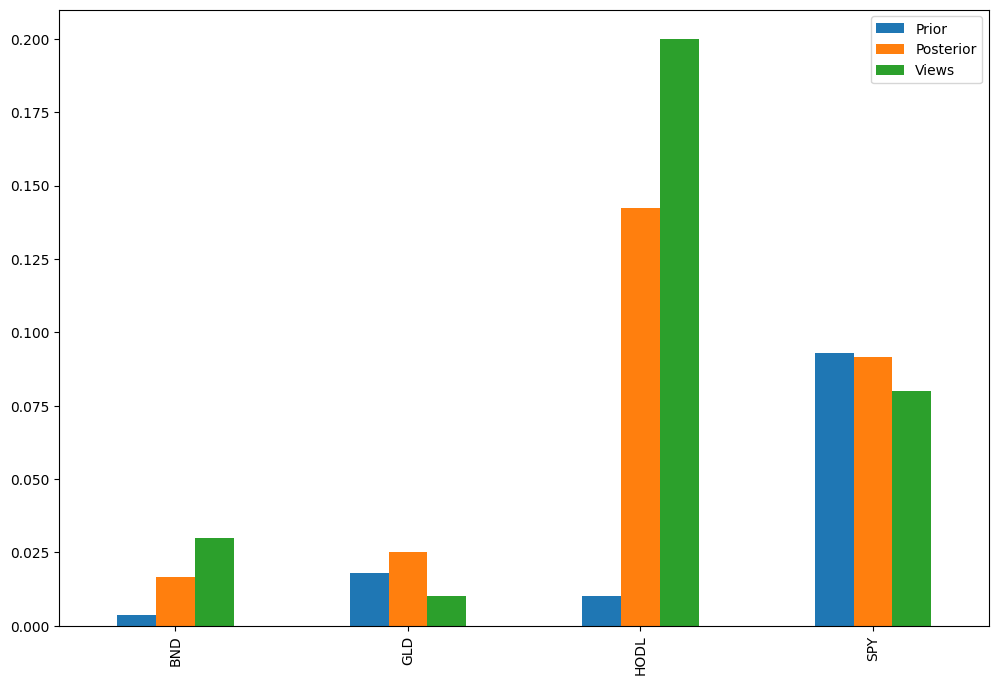

In [223]:
rets_df.plot.bar(figsize=(12,8))
# "Notice that the posterior is often between the prior and the views. 
# This supports the fact that the BL method is essentially a Bayesian weighted-average of the prior and views,
# where the weight is determined by the confidence."

<Axes: >

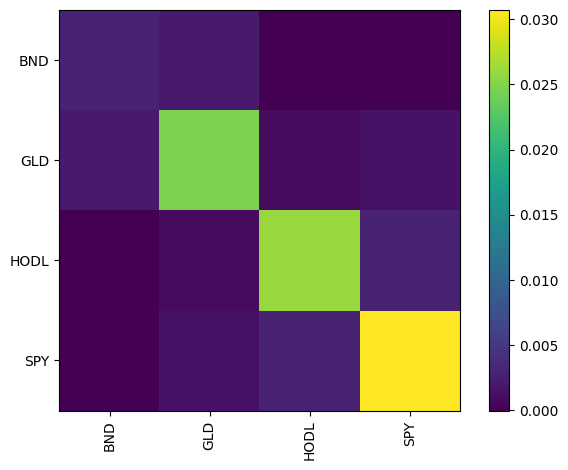

In [224]:
# Posterior covariance estimate:
cov_bl = bl_idzorek.bl_cov()
plotting.plot_covariance(cov_bl)

# Portfolio allocation

In [225]:
from pypfopt import EfficientFrontier, objective_functions

In [226]:
ef = EfficientFrontier(ret_bl, cov_bl)
#ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe() # to maximize sharpe ratio, can be changed
weights = ef.clean_weights()
weights

OrderedDict([('BND', 0.39654),
             ('GLD', 0.01682),
             ('HODL', 0.39902),
             ('SPY', 0.18761)])

<Axes: >

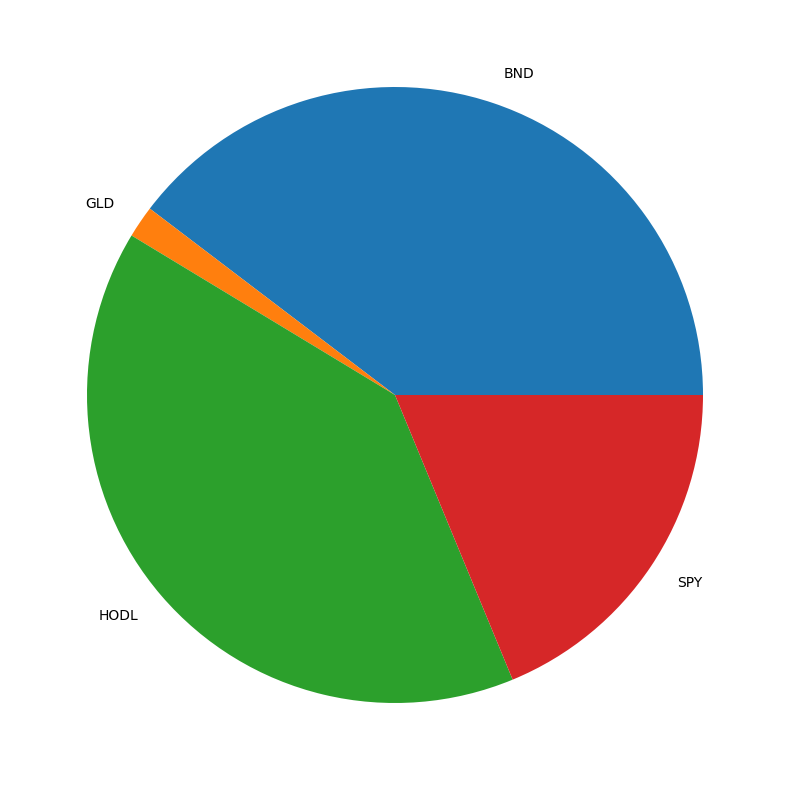

In [227]:
pd.Series(weights).plot.pie(figsize=(10,10))

In [ ]:
# Example of how much to spend in each asset based on capital
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, closing_prices.iloc[-1], total_portfolio_value=10000)
# alloc, leftover = da.lp_portfolio() funkar ej
alloc, leftover = da.greedy_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc #antal andelar

Leftover: $25.78


{'HODL': 177, 'BND': 54, 'SPY': 4}